In [ ]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torchtext
import time
import random
import torch
import re
from textblob import TextBlob

torch.backends.cudnn.deterministic = True

import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(DEVICE)

cuda:1


In [ ]:
import torch
torch.cuda.device_count()

1

In [ ]:
senti = pd.read_csv("/content/drive/MyDrive/MIni_Project/final_senti.csv", index_col=False)

In [ ]:
senti.head()

,Unnamed: 0,user_location,description,Sentiment,user_verified,Length,Word_counts,text,hashtags,Clean tweet,sentiment_score
0,0,Україна,"Only truth, objectivity and breaking news from...",0,False,82,9,Timothy Snyder on Tyranny and on Ukraine \n h...,['WARINUKRAINE'],timothy snyder on tyranny and on ukraine \n 7...,1
1,1,Украина,"Miss Princess Ukraine 2020, Miss Supermodel Gl...",0,False,192,29,Could Ukrainian who stole humanitarian help st...,NaN,could ukrainian who stole humanitarian help st...,1
2,2,NaN,Κακαβρίζω ελεύθερα...,0,False,231,28,NAZI = a member of a group advocating totalita...,NaN,nazi = a member of a group advocating totalita...,1
3,3,NaN,Стоит коммунисту нахмуриться – он становится ф...,1,False,193,27,Thanks to the #Putin I'm waking up because of ...,"['Putin', 'Putin']",thanks to the #putin i'm waking up because of ...,5
4,4,Kyiv 🇺🇦,Я не русофоб. Я їх не боюся. Я їх ненавиджу. Ц...,0,False,295,35,#russists destroyed the National Museum of Gri...,"['russists', 'Skovorodynivka', 'Kharkiv']",#russists destroyed the national museum of gri...,1


In [ ]:
data = senti.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(32465, 11)


,Unnamed: 0,user_location,description,Sentiment,user_verified,Length,Word_counts,text,hashtags,Clean tweet,sentiment_score
0,13304,NaN,NaN,0,False,289,45,@Karmabash This may possibly be from the War i...,NaN,this may possibly be from the war in donbas pr...,3
1,20929,NaN,"🇮🇹 expat in 🇧🇪 | Brussels bubble | EU, ITA & g...",0,False,103,14,#COREPER showing 🇺🇦 pins and dedicate #EuropeD...,"['COREPER', 'EuropeDay', 'Ukraine']",#coreper showing pins and dedicate #europeday...,5
2,19165,🇺🇸🇺🇸🇺🇸🇺🇸,Back again,1,False,127,20,I can’t believe #Putin would make the #Ukraine...,"['Putin', 'Ukraine']",i can’t believe #putin would make the #ukraine...,1
3,7611,India,One of India's largest media companies. Latest...,0,True,161,23,Singer #EltonJohn paid a visit to #Mariupol to...,"['EltonJohn', 'Mariupol']",singer #eltonjohn paid a visit to #mariupol to...,4
4,18263,"Killarney, Kerry, Ireland","Gleneagle Group CEO, #LoveKillarney ROI inc #T...",1,False,121,14,Concert for #Ukraine ⁦@GlenINECArena⁩ thanks t...,"['Ukraine', 'IrishRedCross']",concert for #ukraine ⁦⁩ thanks to all artists ...,5


In [ ]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def clean_tweet(text):
    text = str(text)
    # Remove emojis
    text = emoji_pattern.sub(r'', text)
    # Remove identifications
    text = re.sub(r'@\w+', '', text)
    # Remove links
    text = re.sub(r'http.?://[^/s]+[/s]?', '', text)
    return text.strip().lower()


def analyze_sentiment(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
      return 'negative'

In [ ]:
senti['Sentiment_text'] = senti['text'].apply(lambda x:analyze_sentiment(x))

In [ ]:
senti.head()

,Unnamed: 0,user_location,description,Sentiment,user_verified,Length,Word_counts,text,hashtags,Clean tweet,sentiment_score,Sentiment_text
0,0,Україна,"Only truth, objectivity and breaking news from...",0,False,82,9,Timothy Snyder on Tyranny and on Ukraine \n h...,['WARINUKRAINE'],timothy snyder on tyranny and on ukraine \n 7...,1,neutral
1,1,Украина,"Miss Princess Ukraine 2020, Miss Supermodel Gl...",0,False,192,29,Could Ukrainian who stole humanitarian help st...,NaN,could ukrainian who stole humanitarian help st...,1,neutral
2,2,NaN,Κακαβρίζω ελεύθερα...,0,False,231,28,NAZI = a member of a group advocating totalita...,NaN,nazi = a member of a group advocating totalita...,1,neutral
3,3,NaN,Стоит коммунисту нахмуриться – он становится ф...,1,False,193,27,Thanks to the #Putin I'm waking up because of ...,"['Putin', 'Putin']",thanks to the #putin i'm waking up because of ...,5,positive
4,4,Kyiv 🇺🇦,Я не русофоб. Я їх не боюся. Я їх ненавиджу. Ц...,0,False,295,35,#russists destroyed the National Museum of Gri...,"['russists', 'Skovorodynivka', 'Kharkiv']",#russists destroyed the national museum of gri...,1,negative


In [ ]:
data = senti[['Sentiment_text', 'Clean tweet']]
data.tail()

,Sentiment_text,Clean tweet
32460,neutral,what’s up peeps #freehop #johnnyxmetgala #ukra...
32461,neutral,"on may 9, the russians will arrange a nuclear ..."
32462,positive,"rim-7 sea sparrow missiles have electrolytes, ..."
32463,positive,ukraine is now getting iron dome from israel b...
32464,neutral,erase russia from the map! #fckptn #fckrussi...


In [ ]:
data['Clean tweet'].apply(lambda x: x.lower()) #transform text to lowercase
data['Clean tweet'] = data['Clean tweet'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['Clean tweet'].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    timothy snyder on tyranny and on ukraine \n  7...
1    could ukrainian who stole humanitarian help st...
2    nazi  a member of a group advocating totalitar...
3    thanks to the putin im waking up because of th...
4    russists destroyed the national museum of grig...
Name: Clean tweet, dtype: object

In [ ]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(data['Clean tweet'].values)

X = tokenizer.texts_to_sequences(data['Clean tweet'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   13, 3672,    9,   13,    2,   42],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,  206,   17,   69, 4764,  318,   98,  181,  571,
          17,    9,  206,   31,   11,   29, 4145,   15,  149,   11,   74,
          81,  853, 1255,   15,   98,    4,

In [ ]:
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 76, 256)           1280000   
                                                                 
 dropout (Dropout)           (None, 76, 256)           0         
                                                                 
 lstm (LSTM)                 (None, 76, 256)           525312    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y = pd.get_dummies(data['Sentiment_text']).values
[print(data['Sentiment_text'][i], y[i]) for i in range(0,5)]

neutral [0 1 0]
neutral [0 1 0]
neutral [0 1 0]
positive [0 0 1]
negative [1 0 0]


[None, None, None, None, None]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
batch_size = 32
epochs = 8

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/8
812/812 - 649s - loss: 0.5044 - accuracy: 0.8057 - 649s/epoch - 800ms/step
Epoch 2/8
812/812 - 637s - loss: 0.2382 - accuracy: 0.9303 - 637s/epoch - 785ms/step
Epoch 3/8
812/812 - 634s - loss: 0.1962 - accuracy: 0.9421 - 634s/epoch - 780ms/step
Epoch 4/8
812/812 - 636s - loss: 0.1629 - accuracy: 0.9511 - 636s/epoch - 783ms/step
Epoch 5/8
812/812 - 639s - loss: 0.1321 - accuracy: 0.9591 - 639s/epoch - 786ms/step
Epoch 6/8
812/812 - 637s - loss: 0.1086 - accuracy: 0.9661 - 637s/epoch - 785ms/step
Epoch 7/8
812/812 - 634s - loss: 0.0851 - accuracy: 0.9731 - 634s/epoch - 781ms/step
Epoch 8/8
812/812 - 631s - loss: 0.0665 - accuracy: 0.9794 - 631s/epoch - 777ms/step


2 hours 40 mins to run a cell

In [ ]:
model.save('sentiment_analysis.h5')

In [ ]:
predictions = model.predict(X_test)

[print(data['Clean tweet'][i], predictions[i], y_test[i]) for i in range(0, 5)]

timothy snyder on tyranny and on ukraine 
  76nbdpdycw

warinukraine [7.6081284e-04 3.4111752e-05 9.9920505e-01] [0 0 1]
could ukrainian who stole humanitarian help still called ukrainian and could not russian be blamed for being russian if he sent billions for help to ukraine warinukraine ukraine ukrainewar [3.0008616e-04 3.4888420e-05 9.9966502e-01] [0 0 1]
nazi  a member of a group advocating totalitarian government seeking territorial expansion antisemitist believe in his race supremacy leading to war and genocide putin putinwarcriminal warinukraine sh8a516sty [5.6100974e-04 4.1224212e-05 9.9939775e-01] [0 0 1]
thanks to the putin im waking up because of the shellings and siren he liberated me from a normal life 
putin putinwarcriminal warinukraine standwithukraine ukrainewar russian russia [0.0023376  0.99510443 0.00255793] [0 1 0]
russists destroyed the national museum of grigoriy skovoroda in skovorodynivka village kharkiv region on the night of may 7

bastards want to destroy e

[None, None, None, None, None]

In [ ]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

Positive predictions: 2432
Neutral predictions: 2674
Negative predictions: 1387
Real positive: 2387
Real neutral: 2627
Real negative: 1479


In [ ]:
!pip3 install keras_visualizer

In [ ]:
from keras_visualizer import visualizer 

In [ ]:
from keras.utils.vis_utils import plot_model

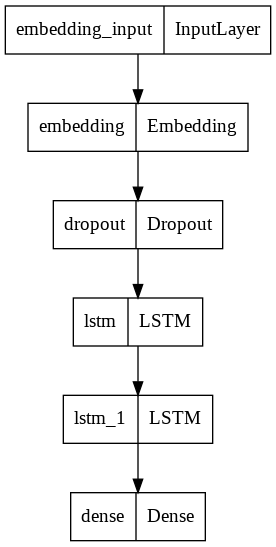

In [ ]:
model = load_model('sentiment_analysis.h5') 
plot_model(model)

#----------------------------------------------------------------------------------------

In [ ]:
visualizer(model, format='png', view=True)